In [1]:
import torch
import torch.nn as nn

import math
import matplotlib.pyplot as plt
import torch.optim as optim
from torch.utils.data import DataLoader

In [2]:
# define the seed
torch.manual_seed(24)


In [3]:
# Initialize the training data set, since we are going to use 2D data, we will initialize a 2D tensor

training_size = 1000
training_data = torch.zeros(training_size, 2)
print(training_data.shape)

torch.Size([1000, 2])


In [4]:
training_data[:, 0] = 2* math.pi * torch.rand(training_size)
training_data[:, 1] = torch.sin(training_data[:, 0])

In [5]:
train_labels = torch.zeros(training_size)
train_set = [(training_data[i], train_labels[i]) for i in range(training_size)]

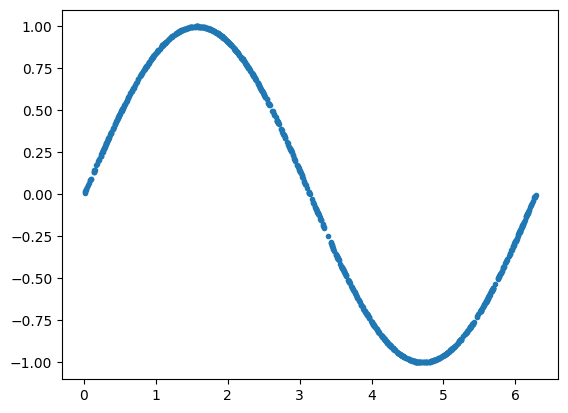

In [6]:
# visualize the training data we have right now

plt.plot(training_data[:, 0], training_data[:, 1], '.')

In [7]:
batch_size = 32

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, drop_last=True)

In [8]:
# define the discriminator here
class Descriminator(nn.Module):
    def __init__(self):
        super(Descriminator, self).__init__()
        self.mlp1 = nn.Linear(2, 256)
        self.acti1 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.2)
        self.mlp2 = nn.Linear(256, 128)
        self.acti2 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.2)
        self.mlp3 = nn.Linear(128, 64)
        self.acti3 = nn.ReLU()
        self.dropout3 = nn.Dropout(0.2)
        self.mlp4 = nn.Linear(64, 1)
        self.acti4 = nn.Sigmoid()

    def forward(self, x):
        x = self.mlp1(x)
        x = self.dropout1(self.acti1(x))
        x = self.mlp2(x)
        x = self.dropout2(self.acti2(x))
        x = self.mlp3(x)
        x = self.dropout3(self.acti3(x))
        x = self.mlp4(x)
        x = self.acti4(x)
        return x   

In [9]:
# define the generator here
class Generator(nn.Module):
    def __init__(self):
        super (Generator, self).__init__()
        self.mlp1 = nn.Linear(2, 16)
        self.acti1 = nn.ReLU()
        self.mlp2 = nn.Linear(16, 32)
        self.acti2 = nn.ReLU()
        self.mlp3 = nn.Linear(32, 64)
        self.acti3 = nn.ReLU()
        self.mlp4 = nn.Linear(64, 32)
        self.acti4 = nn.ReLU()
        self.mlp5 = nn.Linear(32, 2)
    
    def forward(self, x):
        x = self.mlp1(x)
        x = self.acti1(x)
        x = self.mlp2(x)
        x = self.acti2(x)
        x = self.mlp3(x)
        x = self.acti3(x)
        x = self.mlp4(x)
        x = self.acti4(x)
        x = self.mlp5(x)
        return x


In [10]:
lr = 0.001
num_epochs = 500
loss = nn.BCELoss()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [11]:
# Initialize both part of the model
discrinator = Descriminator()
generator = Generator()
generator.to(device)
discrinator.to(device)    


Descriminator(
  (mlp1): Linear(in_features=2, out_features=256, bias=True)
  (acti1): ReLU()
  (dropout1): Dropout(p=0.2, inplace=False)
  (mlp2): Linear(in_features=256, out_features=128, bias=True)
  (acti2): ReLU()
  (dropout2): Dropout(p=0.2, inplace=False)
  (mlp3): Linear(in_features=128, out_features=64, bias=True)
  (acti3): ReLU()
  (dropout3): Dropout(p=0.2, inplace=False)
  (mlp4): Linear(in_features=64, out_features=1, bias=True)
  (acti4): Sigmoid()
)

In [12]:
# there will be two group of parameters, thus we need to define two different optimizers

optimizer_discriminator = optim.Adam(discrinator.parameters(), lr = lr)
optimizer_generator = optim.Adam(generator.parameters(), lr = lr)

c:\Users\ra78lof\AppData\Local\anaconda3\envs\ucd\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


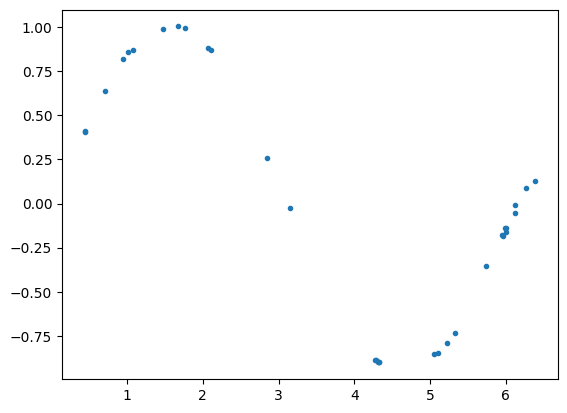

In [13]:
discrinator.train()
generator.train()
for i in range(num_epochs):
    for j, (real_samples, _) in enumerate(train_loader):
        real_samples = real_samples.to(device)
        real_labels = torch.ones(batch_size, 1)
        real_labels = real_labels.to(device)
        latent_z_sample = torch.randn(batch_size, 2) # this would be the z in the original paper, generate one batch of latent z
        latent_z_sample = latent_z_sample.to(device)    
        fake_labels = torch.zeros(batch_size, 1)
        fake_labels = fake_labels.to(device)
        generated_samples = generator(latent_z_sample)  
        all_samples = torch.cat((real_samples, generated_samples))
        all_labels = torch.cat((real_labels, fake_labels)) # half of the labels are real which has value 1, the rest would be fake with value 0
        all_samples = all_samples.to(device)
        all_labels = all_labels.to(device)

        # we first train the D in the paper, aka the discriminator
        discrinator.zero_grad()
        output_dis = discrinator(all_samples)
        loss_dis = loss(output_dis, all_labels)
        loss_dis.backward()
        optimizer_discriminator.step()

        # then we train the G in the paper, aka the generator   
        generator.zero_grad()
        latent_z_sample = torch.randn(batch_size, 2)
        latent_z_sample = latent_z_sample.to(device)
        generated_samples1 = generator(latent_z_sample)
        generated_samples1 = generated_samples1.to(device)
        output_gen = discrinator(generated_samples1)
        loss_gen = loss(output_gen, real_labels)
        loss_gen.backward()
        optimizer_generator.step()

# visualize the generated samples every 20 epochs
generated_samples1 = generated_samples1.detach().cpu()
plt.plot(generated_samples1[:, 0].detach().cpu().numpy(), generated_samples1[:, 1].detach().cpu().numpy(), '.')
plt.show()